---
## Step 1: Setup and Data Collection

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from massive import RESTClient
from scipy import linalg
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully")

Libraries loaded successfully


In [65]:
# S&P 500 stocks with long trading history
# Paper uses N=194 stocks from 1985-2016
SP500_TICKERS = [
    'CMCSA', 'DIS', 'F', 'GPC', 'GT', 'HAS', 'HD', 'HRB', 'IPG',
    'LEG', 'LEN', 'LOW', 'MAT', 'MCD', 'NKE', 'SHW', 'TGT',
    'VFC', 'WHR', 'ADM', 'CAG', 'CL', 'CPB', 'CVS', 'GIS', 'HRL',
    'HSY', 'K', 'KMB', 'KO', 'KR', 'MKC', 'MO', 'SYY', 'TAP', 'TSN',
    'WMT', 'APA', 'COP', 'CVX', 'HAL', 'HP', 'MUR',
    'NBR', 'SLB', 'VLO', 'WMB', 'XOM', 'AFL', 'AIG', 'AON',
    'AXP', 'BAC', 'BBT', 'BEN', 'BK', 'CB', 'CINF', 'CMA', 'C', 'EFX',
    'FHN', 'HBAN', 'HST', 'JPM', 'L', 'LNC', 'MMC',
    'MTB', 'PSA', 'SLM', 'TRV', 'USB', 'VNO', 'WFC', 'WY', 'ZION',
    'ABT', 'AET', 'AMGN', 'BAX', 'BDX', 'BMY', 'CAH', 'CI', 'HUM',
    'JNJ', 'LLY', 'MDT', 'MRK', 'SYK', 'THC', 'TMO', 'UNH',
    'AVY', 'BA', 'CAT', 'CMI', 'CSX', 'CTAS', 'DE', 'DHR', 'DOV',
    'EMR', 'ETN', 'EXPD', 'FDX', 'FLS', 'GD', 'GE', 'GLW', 'GWW', 'HON',
    'ITW', 'LMT', 'LUV', 'MAS', 'MMM', 'ROK', 'TXT',
    'UNP', 'AAPL', 'ADI', 'ADP', 'AMAT', 'AMD', 'HPQ',
    'IBM', 'INTC', 'KLAC', 'LRCX', 'MSI', 'MU', 'TXN', 'WDC', 'XRX',
    'AA', 'APD', 'BMS', 'CLF', 'DD', 'ECL', 'FMC', 'IFF', 'IP',
    'NEM', 'PPG', 'VMC', 'T', 'VZ', 'AEP', 'CMS', 'CNP',
    'D', 'DTE', 'ED', 'EIX', 'EQT', 'ETR', 'EXC', 'NEE', 'NI',
    'PNW', 'SO', 'WEC', 'XEL'
]

# Parameters from paper: M=40 days, Δ=20 days shift
START_DATE = '1985-01-02'  # Adjust based on data availability
END_DATE = '2024-12-31'
EPOCH_SIZE = 40   # M = 40 days
SHIFT = 20        # Δ = 20 days

In [66]:
def fetch_data(tickers, start_date, end_date):
    print(f"Fetching {len(tickers)} stocks from {start_date} to {end_date}...")
    
    data = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        progress=True,
        auto_adjust=True
    )['Close']
    
    data = data.ffill().bfill()
    data = data.dropna(axis=1)
    data = data.dropna(axis=0)

    print(f"Final: {data.shape[0]} trading days, {data.shape[1]} stocks")
    return data

# Fetch data
prices = fetch_data(SP500_TICKERS, START_DATE, END_DATE)
N_STOCKS = prices.shape[1]
print(f"\nN = {N_STOCKS} stocks")

Fetching 166 stocks from 1985-01-02 to 2024-12-31...


[*********************100%***********************]  166 of 166 completed


Final: 10079 trading days, 166 stocks

N = 166 stocks


---
## Step 2: Core Functions (Paper's Methodology)

Key equations from the paper:
- Returns: $r_i(\tau) = \ln P_i(\tau) - \ln P_i(\tau - \Delta)$
- Matrix A: $a_{i,j} = |C_{i,j}|^2$ (to ensure Perron-Frobenius)
- Eigen-centrality: $A|p\rangle = \lambda_1 |p\rangle$ with $\sum_i p_i = 1$
- Eigen-entropy: $H = -\sum_{i=1}^{N} p_i \ln p_i$

In [90]:
def compute_log_returns(prices):
    """Compute log returns: r_i(τ) = ln P_i(τ) - ln P_i(τ-1)"""
    return np.log(prices / prices.shift(1)).dropna()

def compute_correlation_matrix(returns):
    """Compute Pearson correlation matrix C with NaN handling."""
    C = np.corrcoef(returns.T)
    C = np.nan_to_num(C, nan=0.0, posinf=1.0, neginf=-1.0)
    C = (C + C.T) / 2
    np.fill_diagonal(C, 1.0)
    
    return C

def correlation_to_A_matrix(C):
    """
    Convert correlation matrix C to matrix A = |C|^2.
    This ensures non-negative entries for Perron-Frobenius theorem.
    Paper uses n=2 (squared).
    """
    return np.abs(C) ** 2

def compute_eigen_centrality(A):
    """
    Compute eigen-centrality from matrix A.
    Returns normalized eigenvector of largest eigenvalue.
    p_i >= 0 and sum(p_i) = 1
    """
    eigenvalues, eigenvectors = linalg.eigh(A)
    # Get eigenvector for largest eigenvalue
    idx_max = np.argmax(eigenvalues)
    v = eigenvectors[:, idx_max]
    # Ensure non-negative (by Perron-Frobenius, should be)
    v = np.abs(v)
    # Normalize so sum = 1
    p = v / np.sum(v)
    return p

def compute_entropy(p):
    """
    Compute Shannon entropy: H = -sum(p_i * ln(p_i))
    """
    p_nonzero = p[p > 1e-12]
    return -np.sum(p_nonzero * np.log(p_nonzero))

In [91]:
def decompose_correlation_matrix(C):
    """
    Decompose C into market mode C_M and group-random mode C_GR.
    
    C = C_M + C_GR
    C_M = λ₁|e₁⟩⟨e₁|  (rank-1 matrix from largest eigenvalue)
    C_GR = Σᵢ₌₂ᴺ λᵢ|eᵢ⟩⟨eᵢ|  (all other eigenvalues)
    """
    C = np.nan_to_num(C, nan=0.0, posinf=1.0, neginf=-1.0)
    C = (C + C.T) / 2
    np.fill_diagonal(C, 1.0)
    eigenvalues, eigenvectors = linalg.eigh(C)
    
    # Sort by eigenvalue (descending)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    N = len(eigenvalues)
    
    # Market mode: C_M = λ₁ * |e₁⟩⟨e₁|
    e1 = eigenvectors[:, 0].reshape(-1, 1)
    C_M = eigenvalues[0] * (e1 @ e1.T)
    
    # Group-Random mode: C_GR = sum over i=2 to N
    C_GR = np.zeros_like(C)
    for i in range(1, N):
        ei = eigenvectors[:, i].reshape(-1, 1)
        C_GR += eigenvalues[i] * (ei @ ei.T)
    
    return C_M, C_GR, eigenvalues, eigenvectors

def compute_three_entropies(C):
    """
    Compute all three entropies as in the paper:
    - H: from full correlation matrix C
    - H_M: from market mode C_M
    - H_GR: from group-random mode C_GR
    """
    # Decompose C
    C_M, C_GR, eigenvalues, eigenvectors = decompose_correlation_matrix(C)
    
    # Convert to A matrices (squared entries)
    A = correlation_to_A_matrix(C)
    A_M = correlation_to_A_matrix(C_M)
    A_GR = correlation_to_A_matrix(C_GR)
    
    # Compute eigen-centralities
    p = compute_eigen_centrality(A)
    p_M = compute_eigen_centrality(A_M)
    p_GR = compute_eigen_centrality(A_GR)
    
    # Compute entropies
    H = compute_entropy(p)
    H_M = compute_entropy(p_M)
    H_GR = compute_entropy(p_GR)
    
    return H, H_M, H_GR, eigenvalues

---
## Step 3: Single Epoch Demonstration

In [92]:
# Compute returns
returns = compute_log_returns(prices)
print(f"Returns shape: {returns.shape}")

# Single epoch example
sample_returns = returns.iloc[:EPOCH_SIZE].values
C = compute_correlation_matrix(sample_returns)

print(f"\nCorrelation matrix shape: {C.shape}")
print(f"Mean correlation: {C[np.triu_indices(len(C), k=1)].mean():.4f}")

Returns shape: (10078, 166)

Correlation matrix shape: (166, 166)
Mean correlation: 0.1227


In [93]:
# Compute three entropies for single epoch
C = (C + C.T) / 2  
np.fill_diagonal(C, 1.0)
H, H_M, H_GR, eigenvalues = compute_three_entropies(C)
ratio = H_GR / H_M

# Maximum entropy (Wishart/WOE limit)
H_max = np.log(N_STOCKS)

print(f"N = {N_STOCKS} stocks")
print(f"\nEntropies:")
print(f"  H (full):        {H:.4f}")
print(f"  H_M (market):    {H_M:.4f}")
print(f"  H_GR (group-random): {H_GR:.4f}")
print(f"  H_max (ln N):    {H_max:.4f}")
print(f"\nPhase space coordinates:")
print(f"  |H - H_M|:  {np.abs(H - H_M):.4f}")
print(f"  |H - H_GR|: {np.abs(H - H_GR):.4f}")

lambda1 = eigenvalues[0]  
print(f"Largest eigenvalue (λ₁) = {lambda1:.2f} (MP bound: {(1 + np.sqrt(len(C)/EPOCH_SIZE))**2:.2f})")

N = 166 stocks

Entropies:
  H (full):        4.9167
  H_M (market):    4.7063
  H_GR (group-random): 5.0524
  H_max (ln N):    5.1120

Phase space coordinates:
  |H - H_M|:  0.2105
  |H - H_GR|: 0.1356
Largest eigenvalue (λ₁) = 29.20 (MP bound: 9.22)


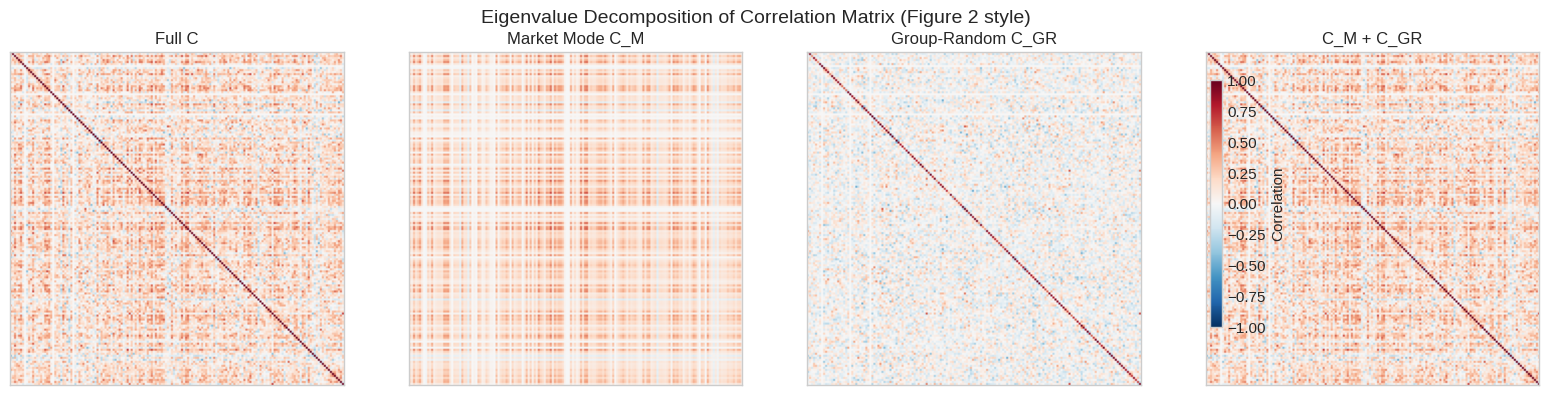

In [94]:
# Visualize correlation matrix and its decomposition
C_M, C_GR, _, _ = decompose_correlation_matrix(C)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

titles = ['Full C', 'Market Mode C_M', 'Group-Random C_GR', 'C_M + C_GR']
matrices = [C, C_M, C_GR, C_M + C_GR]

for ax, title, mat in zip(axes, titles, matrices):
    im = ax.imshow(mat, cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set_title(title, fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

plt.colorbar(im, ax=axes, shrink=0.8, label='Correlation')
plt.suptitle('Eigenvalue Decomposition of Correlation Matrix (Figure 2 style)', fontsize=14)
plt.tight_layout()
plt.show()

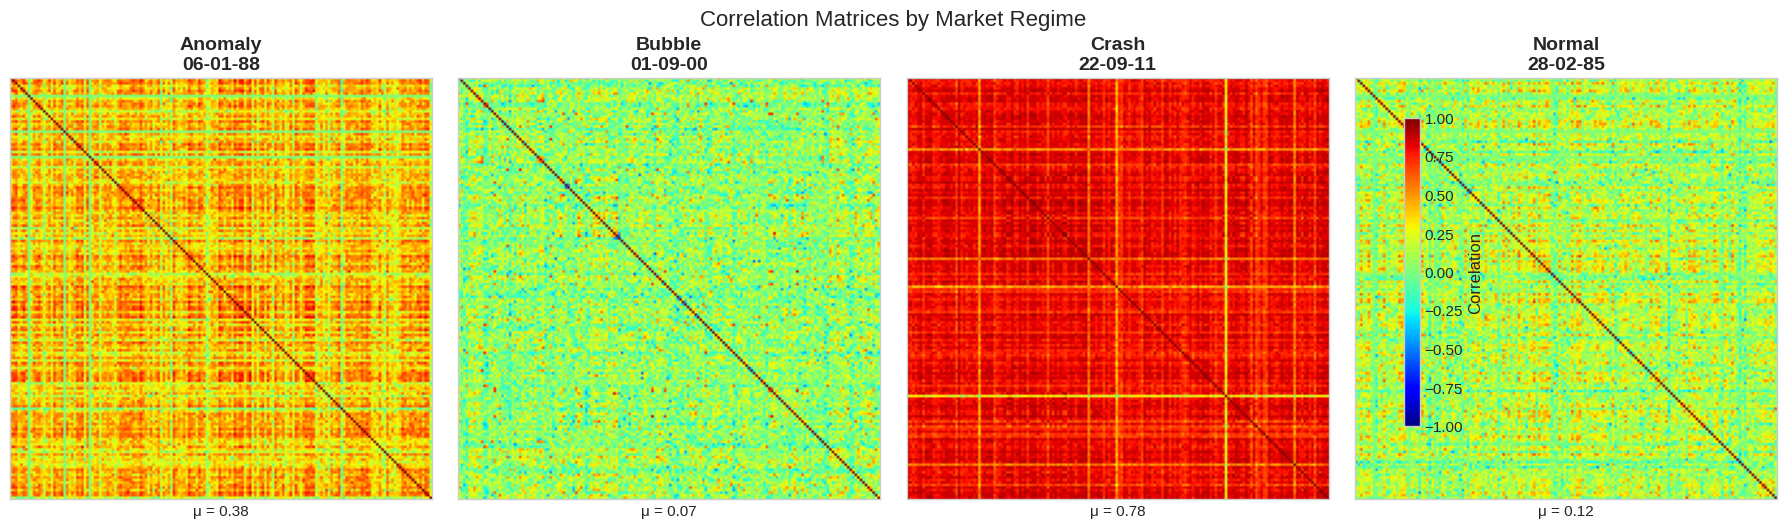

In [104]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Function to get correlation matrix for a specific date (FIXED)
def get_correlation_for_date(target_date, returns_df, epoch_size=40):
    """Get correlation matrix for the epoch ending at target_date"""
    target = pd.Timestamp(target_date)
    
    # Find closest date using searchsorted
    idx = returns_df.index.searchsorted(target)
    end_idx = min(idx, len(returns_df) - 1)
    start_idx = max(0, end_idx - epoch_size + 1)
    
    epoch_returns = returns_df.iloc[start_idx:end_idx+1].values
    C = compute_correlation_matrix(epoch_returns)
    return C, returns_df.index[end_idx]

# EXACT dates from the paper (DD-MM-YY format in paper)
regime_examples = {
    'Anomaly': '1988-01-06',   # 06-01-88
    'Bubble': '2000-09-01',    # 01-09-00
    'Crash': '2011-09-22',     # 22-09-11
    'Normal': '1985-02-28',    # 28-02-85
}

# Plot each regime's correlation matrix
for ax, (regime, date) in zip(axes, regime_examples.items()):
    try:
        C, actual_date = get_correlation_for_date(date, returns, EPOCH_SIZE)
        
        # Use jet colormap like paper
        im = ax.imshow(C, cmap='jet', vmin=-1, vmax=1, aspect='equal')
        
        # Format date as DD-MM-YY (matching paper)
        date_str = actual_date.strftime('%d-%m-%y')
        ax.set_title(f'{regime}\n{date_str}', fontsize=14, fontweight='bold')
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Calculate mean correlation for this epoch
        upper_tri = np.triu_indices(C.shape[0], k=1)
        mu = np.mean(C[upper_tri])
        ax.set_xlabel(f'μ = {mu:.2f}', fontsize=11)
        
    except Exception as e:
        ax.set_title(f'{regime}\n(Error)')
        print(f"Error for {regime}: {e}")

# Add colorbar
cbar = fig.colorbar(im, ax=axes, shrink=0.8, pad=0.02)
cbar.set_label('Correlation', fontsize=12)

plt.suptitle('Correlation Matrices by Market Regime', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

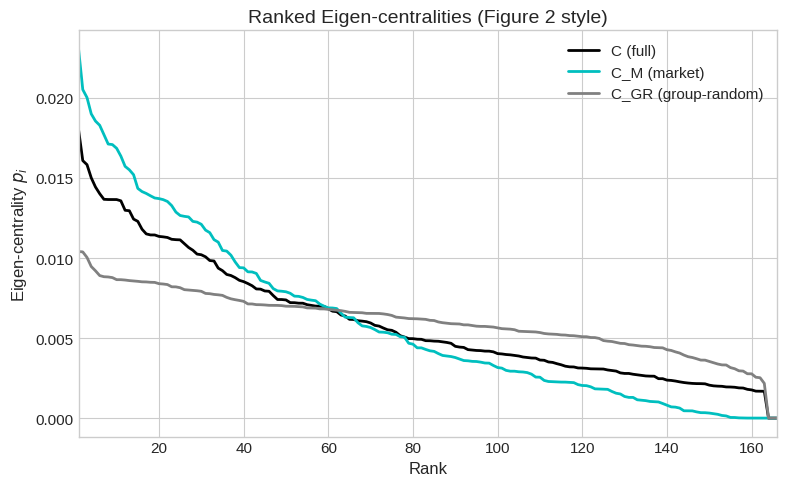

In [72]:
fig, ax = plt.subplots(figsize=(8, 5))

# Get eigen-centralities
A = correlation_to_A_matrix(C)
A_M = correlation_to_A_matrix(C_M)
A_GR = correlation_to_A_matrix(C_GR)

p = compute_eigen_centrality(A)
p_M = compute_eigen_centrality(A_M)
p_GR = compute_eigen_centrality(A_GR)

# Plot ranked (sorted descending)
ranks = np.arange(1, len(p) + 1)
ax.plot(ranks, np.sort(p)[::-1], 'k-', linewidth=2, label='C (full)')
ax.plot(ranks, np.sort(p_M)[::-1], 'c-', linewidth=2, label='C_M (market)')
ax.plot(ranks, np.sort(p_GR)[::-1], 'gray', linewidth=2, label='C_GR (group-random)')

ax.set_xlabel('Rank', fontsize=12)
ax.set_ylabel('Eigen-centrality $p_i$', fontsize=12)
ax.set_title('Ranked Eigen-centralities (Figure 2 style)', fontsize=14)
ax.legend()
ax.set_xlim([1, len(p)])
plt.tight_layout()
plt.show()

---
## Step 4: Rolling Window Analysis

In [73]:
def rolling_window_analysis(returns_df, epoch_size=40, shift=20):
    """
    Perform rolling window analysis following the paper exactly.
    Computes H, H_M, H_GR for each epoch.
    """
    returns = returns_df.values
    dates = returns_df.index
    N = returns.shape[1]
    H_max = np.log(N)  # Wishart limit
    
    results = []
    start = 0
    
    while start + epoch_size <= len(returns):
        epoch_returns = returns[start:start + epoch_size]
        epoch_end_date = dates[start + epoch_size - 1]
        
        # Correlation matrix
        C = compute_correlation_matrix(epoch_returns)
        
        # Three entropies (paper's method)
        H, H_M, H_GR, eigenvalues = compute_three_entropies(C)
        
        # Mean market correlation μ
        upper_tri = np.triu_indices(N, k=1)
        mu = np.mean(C[upper_tri])
        
        # Phase space coordinates
        H_minus_HM = H - H_M
        H_minus_HGR = H - H_GR
        HM_minus_HGR = H_M - H_GR
        
        # Largest eigenvalue
        lambda_max = eigenvalues[0]
        
        results.append({
            'date': epoch_end_date,
            'H': H,
            'H_M': H_M,
            'H_GR': H_GR,
            'H_max': H_max,
            'H_minus_HM': H_minus_HM,
            'H_minus_HGR': H_minus_HGR,
            'HM_minus_HGR': HM_minus_HGR,
            'abs_H_minus_HM': np.abs(H_minus_HM),
            'abs_H_minus_HGR': np.abs(H_minus_HGR),
            'mu': mu,  # mean correlation
            'lambda_max': lambda_max,
        })
        
        start += shift
        
    return pd.DataFrame(results)

In [74]:
# Run rolling window analysis
print(f"Running rolling window analysis (M={EPOCH_SIZE}, Δ={SHIFT})...")
results = rolling_window_analysis(returns, epoch_size=EPOCH_SIZE, shift=SHIFT)

print(f"\nAnalyzed {len(results)} epochs")
print(f"Date range: {results['date'].min()} to {results['date'].max()}")
results.head(10)

Running rolling window analysis (M=40, Δ=20)...

Analyzed 502 epochs
Date range: 1985-02-28 00:00:00 to 2024-12-03 00:00:00


date         H       H_M      H_GR     H_max  H_minus_HM  H_minus_HGR  \
0 1985-02-28  4.916730  4.706267  5.052355  5.111988    0.210462    -0.135625   
1 1985-03-28  4.944822  4.696430  5.054366  5.111988    0.248392    -0.109544   
2 1985-04-26  4.954032  4.665112  5.061329  5.111988    0.288921    -0.107297   
3 1985-05-24  4.932023  4.750202  5.053424  5.111988    0.181821    -0.121401   
4 1985-06-24  4.949979  4.772790  5.053063  5.111988    0.177189    -0.103084   
5 1985-07-23  5.008602  4.709056  5.057967  5.111988    0.299546    -0.049365   
6 1985-08-20  4.966442  4.764012  5.057011  5.111988    0.202430    -0.090568   
7 1985-09-18  4.947258  4.761066  5.045632  5.111988    0.186192    -0.098373   
8 1985-10-17  4.932913  4.754327  5.057619  5.111988    0.178585    -0.124706   
9 1985-11-14  4.941448  4.739709  5.057897  5.111988    0.201739    -0.116449   

   HM_minus_HGR  abs_H_minus_HM  abs_H_minus_HGR        mu  lambda_max  
0     -0.346087        0.210462         0.135625  0.122742   29.202254  
1     -0.357937        0.248392         0.109544  0.111512   26.788764  
2     -0.396218        0.288921         0.107297  0.097479   24.589345  
3     -0.303222        0.181821         0.121401  0.136124   31.099053  
4     -0.280272        0.177189         0.103084  0.138446   30.747052  
5     -0.348911        0.299546         0.049365  0.085332   20.937024  
6     -0.292998        0.202430         0.090568  0.128473   28.642672  
7     -0.284566        0.186192         0.098373  0.137612   30.824448  
8     -0.303292        0.178585         0.124706  0.141190   30.873974  
9     -0.318188        0.201739         0.116449  0.132144   29.440829

---
## Step 5: Regime Identification

Known market events for labeling (from paper's Table S1):

In [75]:
MARKET_EVENTS = {
    'crashes': [
        # Pre-2000 events (from paper's Table S3)
        ('1987-10-19', '1987-10-30', 'Black Monday'),
        ('1989-10-13', '1989-10-20', 'Friday 13th Mini Crash'),
        ('1990-01-01', '1990-12-31', 'Early 90s Recession'),
        ('1997-10-27', '1997-11-15', 'Asian Financial Crisis'),
        # 2000s events
        ('2000-03-10', '2000-04-14', 'Dot-com Crash'),
        ('2001-09-11', '2001-09-30', '9/11 Financial Crisis'),
        ('2002-09-01', '2002-10-15', 'Stock Market Downturn 2002'),
        ('2008-09-15', '2008-11-30', 'Lehman Brothers Crash'),
        ('2010-05-06', '2010-05-20', 'DJ Flash Crash'),
        ('2011-03-11', '2011-03-25', 'Tsunami/Fukushima'),
        ('2011-08-08', '2011-08-31', 'August 2011 Markets Fall'),
        ('2015-08-24', '2015-09-15', 'Chinese Black Monday'),
        ('2018-02-02', '2018-02-09', 'Volatility spike'),
        ('2020-02-20', '2020-03-23', 'COVID Crash'),
    ],
    'bubbles': [
        ('1999-01-01', '2000-03-09', 'Dot-com Bubble'),
        ('2005-01-01', '2007-10-01', 'US Housing Bubble'),
        ('2021-01-01', '2021-11-15', 'Post-COVID Rally'),
    ]
}

print(f"Total crash events: {len(MARKET_EVENTS['crashes'])}")
print(f"Total bubble events: {len(MARKET_EVENTS['bubbles'])}")

Total crash events: 14
Total bubble events: 3


In [76]:
def identify_regimes(df, events):
    """Label epochs based on known market events."""
    df = df.copy()
    df['regime'] = 'normal'
    df['event_name'] = ''
    
    for start, end, name in events['crashes']:
        mask = (df['date'] >= start) & (df['date'] <= end)
        df.loc[mask, 'regime'] = 'crash'
        df.loc[mask, 'event_name'] = name
    
    for start, end, name in events['bubbles']:
        mask = (df['date'] >= start) & (df['date'] <= end)
        df.loc[mask, 'regime'] = 'bubble'
        df.loc[mask, 'event_name'] = name
    
    # Type-1 events: High |H - H_M| AND high |H - H_GR| (far from origin)
    # Type-2 events: Near one axis (anomalies near crashes)
    threshold_HM = df['abs_H_minus_HM'].quantile(0.90)
    threshold_HGR = df['abs_H_minus_HGR'].quantile(0.90)
    
    type1_mask = (df['abs_H_minus_HM'] > threshold_HM) & \
                 (df['abs_H_minus_HGR'] > threshold_HGR) & \
                 (df['regime'] == 'normal')
    df.loc[type1_mask, 'regime'] = 'type-1'
    
    return df

results = identify_regimes(results, MARKET_EVENTS)
print("Regime Distribution:")
print(results['regime'].value_counts())

Regime Distribution:
regime
normal    417
bubble     60
crash      24
type-1      1
Name: count, dtype: int64


---
## Step 6: Reproduce Paper's Figures

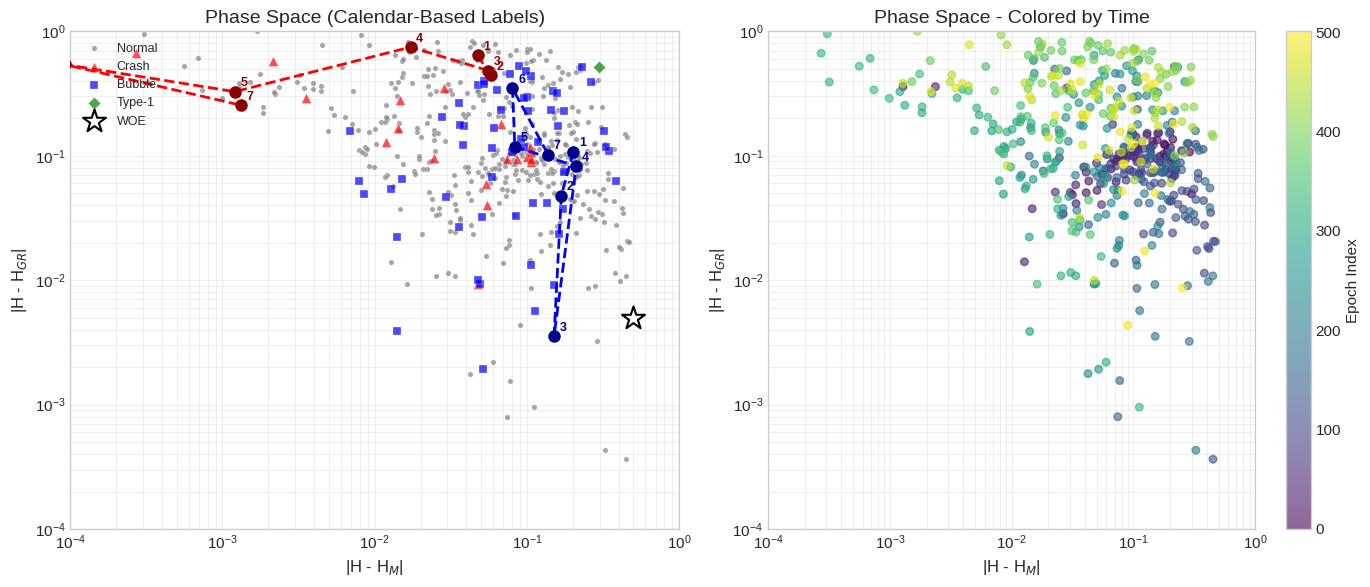

In [77]:
# =============================================================================
# FIGURE 3: PHASE SPACE (CALENDAR-BASED REGIME CLASSIFICATION)
# =============================================================================

# Color scheme matching paper
COLORS = {
    'normal': 'gray',
    'crash': 'red',
    'bubble': 'blue',
    'type-1': 'green',
    'type-2': 'purple',
}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# =============================================================================
# LEFT PLOT: Phase space with calendar-based regime colors
# =============================================================================
ax = axes[0]

# Different markers for different regimes (like paper)
MARKERS = {
    'normal': ('o', 15),   # small circle
    'crash': ('^', 50),    # triangle
    'bubble': ('s', 40),   # square
    'type-1': ('D', 40),   # diamond
}

for regime in ['normal', 'crash', 'bubble', 'type-1']:
    mask = results['regime'] == regime
    if mask.any():
        marker, size = MARKERS[regime]
        ax.scatter(results.loc[mask, 'abs_H_minus_HM'] + 1e-6,
                  results.loc[mask, 'abs_H_minus_HGR'] + 1e-6,
                  c=COLORS[regime], marker=marker, s=size,
                  label=regime.capitalize(),
                  alpha=0.7, edgecolors='white', linewidth=0.3, zorder=2)

# WOE reference - BOTTOM-RIGHT (high |H-H_M|, low |H-H_GR|)
ax.scatter([0.5], [0.005], c='white', marker='*', s=300, 
           edgecolors='black', linewidth=1.5, label='WOE', zorder=5)

# Transition sequences
def get_transition_sequence(results_df, event_date, n_before=3, n_after=3):
    results_df = results_df.reset_index(drop=True)
    date_diffs = (results_df['date'] - pd.Timestamp(event_date)).abs()
    center_idx = date_diffs.idxmin()
    start_idx = max(0, center_idx - n_before)
    end_idx = min(len(results_df) - 1, center_idx + n_after)
    return results_df.iloc[start_idx:end_idx + 1]

# Crash transition (Lehman 2008)
crash_seq = get_transition_sequence(results, '2008-09-15', 3, 3)
if len(crash_seq) > 1:
    x = crash_seq['abs_H_minus_HM'].values + 1e-6
    y = crash_seq['abs_H_minus_HGR'].values + 1e-6
    ax.plot(x, y, 'r--', linewidth=2, zorder=4, marker='o', markersize=8,
            markerfacecolor='darkred', markeredgecolor='darkred')
    for i, (xi, yi) in enumerate(zip(x, y)):
        ax.annotate(str(i+1), (xi, yi), fontsize=9, fontweight='bold',
                   color='darkred', xytext=(4, 4), textcoords='offset points', zorder=6)

# Bubble transition (Dot-com 2000)
bubble_seq = get_transition_sequence(results, '2000-03-10', 3, 3)
if len(bubble_seq) > 1:
    x = bubble_seq['abs_H_minus_HM'].values + 1e-6
    y = bubble_seq['abs_H_minus_HGR'].values + 1e-6
    ax.plot(x, y, 'b--', linewidth=2, zorder=4, marker='o', markersize=8,
            markerfacecolor='darkblue', markeredgecolor='darkblue')
    for i, (xi, yi) in enumerate(zip(x, y)):
        ax.annotate(str(i+1), (xi, yi), fontsize=9, fontweight='bold',
                   color='darkblue', xytext=(4, 4), textcoords='offset points', zorder=6)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('|H - H$_M$|', fontsize=12)
ax.set_ylabel('|H - H$_{GR}$|', fontsize=12)
ax.set_title('Phase Space (Calendar-Based Labels)', fontsize=14)
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3, which='both')
ax.set_xlim([1e-4, 1e0])
ax.set_ylim([1e-4, 1e0])

# =============================================================================
# RIGHT PLOT: Colored by time
# =============================================================================
ax = axes[1]
scatter = ax.scatter(results['abs_H_minus_HM'] + 1e-6,
                    results['abs_H_minus_HGR'] + 1e-6,
                    c=range(len(results)), cmap='viridis',
                    alpha=0.6, s=30)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('|H - H$_M$|', fontsize=12)
ax.set_ylabel('|H - H$_{GR}$|', fontsize=12)
ax.set_title('Phase Space - Colored by Time', fontsize=14)
plt.colorbar(scatter, ax=ax, label='Epoch Index')
ax.grid(True, alpha=0.3, which='both')
ax.set_xlim([1e-4, 1e0])
ax.set_ylim([1e-4, 1e0])

plt.tight_layout()
plt.show()


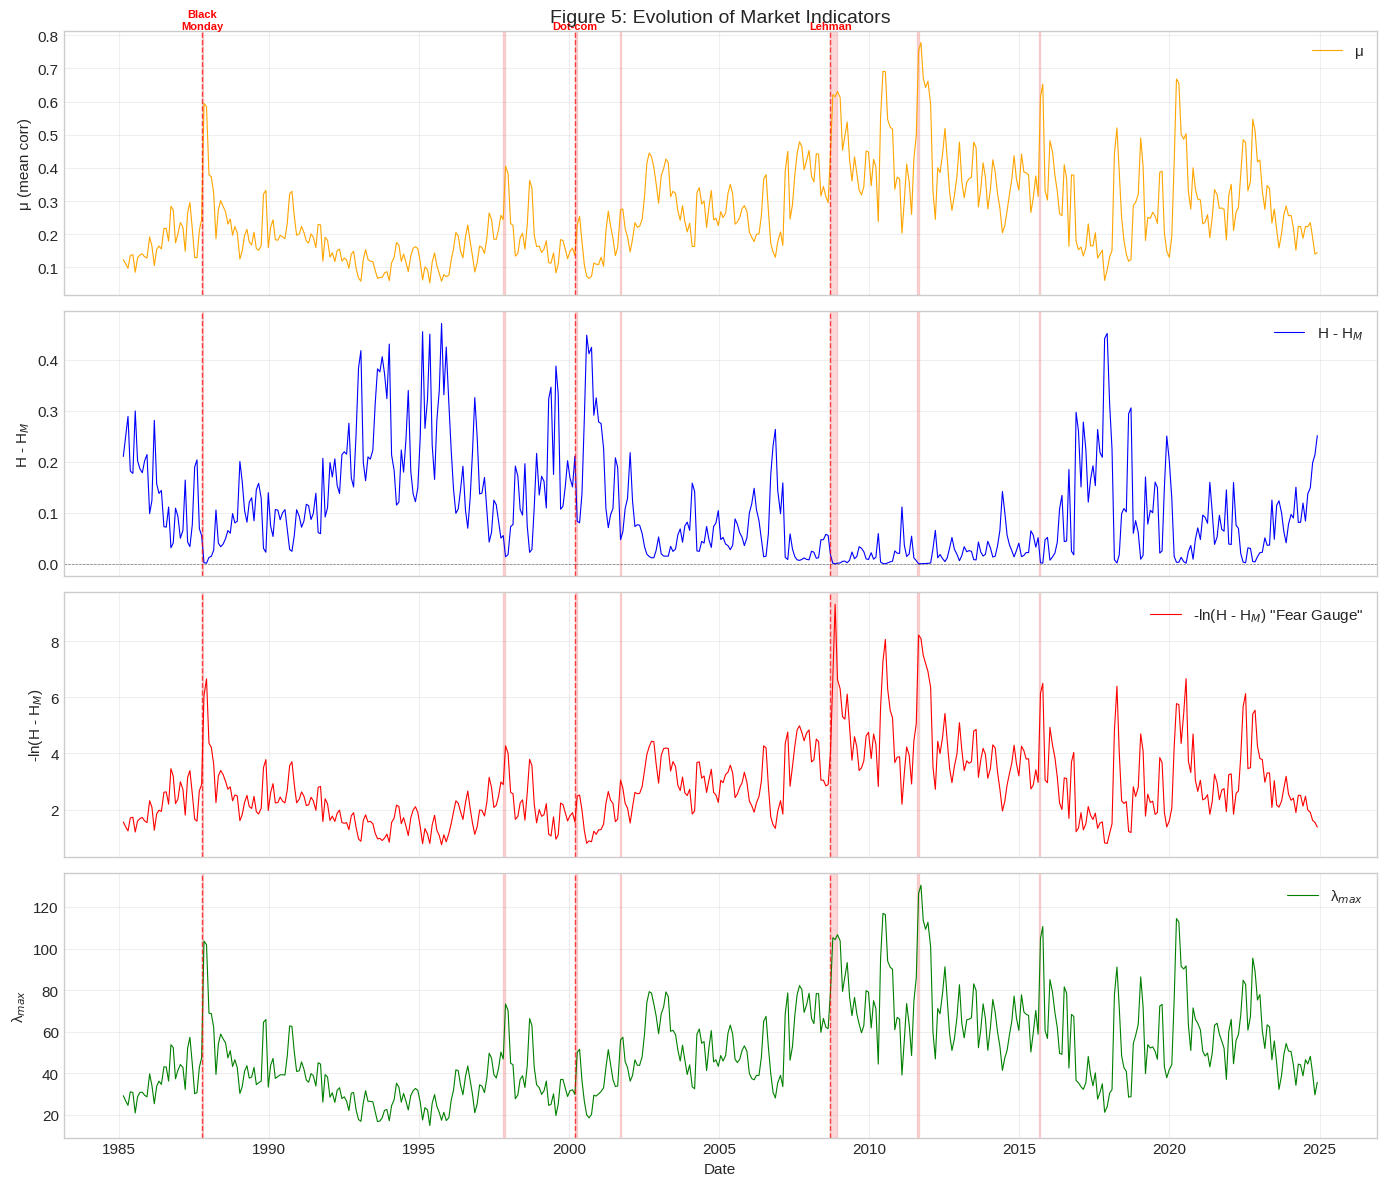

In [78]:
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Crisis periods for shading
crisis_periods = [
    ('1987-10-19', '1987-10-30', 'Black Monday'),
    ('1997-10-27', '1997-11-15', 'Asian Crisis'),
    ('2000-03-10', '2000-04-14', 'Dot-com Crash'),
    ('2001-09-11', '2001-09-30', '9/11'),
    ('2008-09-15', '2008-11-30', 'Lehman'),
    ('2011-08-08', '2011-08-31', 'Aug 2011'),
    ('2015-08-24', '2015-09-15', 'China'),
]

# Panel 1: Mean correlation μ
ax = axes[0]
ax.plot(results['date'], results['mu'], color='orange', linewidth=0.8, label='μ')
ax.set_ylabel('μ (mean corr)', fontsize=11)
ax.set_title('Figure 5: Evolution of Market Indicators', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Panel 2: H - H_M
ax = axes[1]
ax.plot(results['date'], results['H_minus_HM'], color='blue', linewidth=0.8, label='H - H$_M$')
ax.set_ylabel('H - H$_M$', fontsize=11)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Panel 3: -ln(H - H_M) - "fear gauge" similar to VIX
ax = axes[2]
neg_ln = -np.log(results['H_minus_HM'].clip(lower=1e-10))
ax.plot(results['date'], neg_ln, color='red', linewidth=0.8, label='-ln(H - H$_M$) "Fear Gauge"')
ax.set_ylabel('-ln(H - H$_M$)', fontsize=11)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Panel 4: Largest eigenvalue
ax = axes[3]
ax.plot(results['date'], results['lambda_max'], color='green', linewidth=0.8, label='λ$_{max}$')
ax.set_ylabel('λ$_{max}$', fontsize=11)
ax.set_xlabel('Date', fontsize=11)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Add crisis bands to all panels
crisis_added = False
for ax in axes:
    for start, end, name in crisis_periods:
        try:
            if not crisis_added:
                ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), 
                          color='lightcoral', alpha=0.3, label='Crisis Period')
                crisis_added = True
            else:
                ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), 
                          color='lightcoral', alpha=0.3)
        except:
            pass
    crisis_added = False  # Reset for next panel

# Add vertical lines for major crashes with labels (only on top panel)
major_crashes = [
    ('1987-10-19', 'Black\nMonday'),
    ('2000-03-10', 'Dot-com'),
    ('2008-09-15', 'Lehman'),
]

for date, label in major_crashes:
    try:
        for ax in axes:
            ax.axvline(pd.Timestamp(date), color='red', linestyle='--', linewidth=1, alpha=0.7)
        # Add label only to top panel
        axes[0].annotate(label, xy=(pd.Timestamp(date), axes[0].get_ylim()[1]), 
                        fontsize=8, ha='center', va='bottom', color='red', fontweight='bold')
    except:
        pass

plt.tight_layout()
plt.show()


Scaling fit: (H - H_M) ~ 0.786 * exp(-9.87 * μ)
Paper values: α ≈ 0.85, β ≈ 10.22


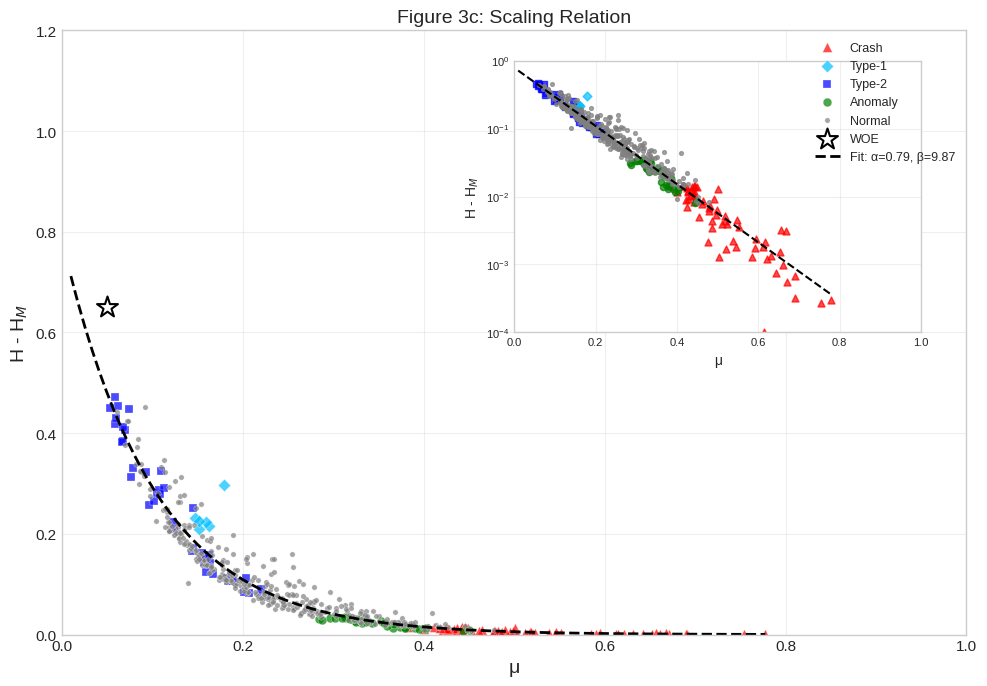

In [79]:
from scipy.optimize import curve_fit

fig, ax = plt.subplots(figsize=(10, 7))

# Use phase-space-based regimes for coloring
results_plot = results.copy()

H_HM_low = results_plot['abs_H_minus_HM'].quantile(0.15)
H_HM_high = results_plot['abs_H_minus_HM'].quantile(0.85)
H_HGR_low = results_plot['abs_H_minus_HGR'].quantile(0.15)
H_HGR_high = results_plot['abs_H_minus_HGR'].quantile(0.85)

results_plot['phase_regime'] = 'Normal'

crash_mask = (results_plot['abs_H_minus_HM'] < H_HM_low) & \
             (results_plot['abs_H_minus_HGR'] > results_plot['abs_H_minus_HGR'].quantile(0.5))
results_plot.loc[crash_mask, 'phase_regime'] = 'Crash'

type1_mask = (results_plot['abs_H_minus_HM'] > H_HM_high) & \
             (results_plot['abs_H_minus_HGR'] > H_HGR_high)
results_plot.loc[type1_mask, 'phase_regime'] = 'Type-1'

type2_mask = (results_plot['abs_H_minus_HM'] > results_plot['abs_H_minus_HM'].quantile(0.5)) & \
             (results_plot['abs_H_minus_HGR'] < H_HGR_low)
results_plot.loc[type2_mask, 'phase_regime'] = 'Type-2'

anomaly_mask = (results_plot['abs_H_minus_HM'] < results_plot['abs_H_minus_HM'].quantile(0.3)) & \
               (results_plot['abs_H_minus_HGR'] < results_plot['abs_H_minus_HGR'].quantile(0.3))
results_plot.loc[anomaly_mask, 'phase_regime'] = 'Anomaly'

# Marker styles matching paper
MARKERS = {
    'Crash': ('^', 'red', 50),
    'Type-1': ('D', 'deepskyblue', 40),
    'Type-2': ('s', 'blue', 40),
    'Anomaly': ('o', 'green', 40),
    'Normal': ('o', 'gray', 15),
}

# Plot colored by regime
for regime, (marker, color, size) in MARKERS.items():
    mask = results_plot['phase_regime'] == regime
    if mask.any():
        ax.scatter(results_plot.loc[mask, 'mu'], 
                  results_plot.loc[mask, 'H_minus_HM'],
                  marker=marker, c=color, s=size, label=regime,
                  alpha=0.7, edgecolors='white', linewidth=0.3)

# WOE reference point (high μ, H-H_M ≈ 0)
ax.scatter([0.05], [0.65], c='white', marker='*', s=250, 
           edgecolors='black', linewidth=1.5, label='WOE', zorder=5)

# Exponential fit: (H - H_M) ~ α * exp(-β * μ)
def exp_func(x, alpha, beta):
    return alpha * np.exp(-beta * x)

try:
    mask = (results_plot['H_minus_HM'] > 0.001) & (results_plot['mu'] > 0.01)
    x_data = results_plot.loc[mask, 'mu'].values
    y_data = results_plot.loc[mask, 'H_minus_HM'].values
    
    popt, pcov = curve_fit(exp_func, x_data, y_data, p0=[0.85, 10], maxfev=10000)
    
    x_fit = np.linspace(0.01, results_plot['mu'].max(), 100)
    y_fit = exp_func(x_fit, *popt)
    ax.plot(x_fit, y_fit, 'k--', linewidth=2, 
            label=f'Fit: α={popt[0]:.2f}, β={popt[1]:.2f}')
    
    print(f"Scaling fit: (H - H_M) ~ {popt[0]:.3f} * exp(-{popt[1]:.2f} * μ)")
    print(f"Paper values: α ≈ 0.85, β ≈ 10.22")
except Exception as e:
    print(f"Fit failed: {e}")

ax.set_xlabel('μ', fontsize=14)
ax.set_ylabel('H - H$_M$', fontsize=14)
ax.set_title('Figure 3c: Scaling Relation', fontsize=14)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.2])

# Add inset with log scale (like paper)
inset = ax.inset_axes([0.5, 0.5, 0.45, 0.45])

for regime, (marker, color, size) in MARKERS.items():
    mask = results_plot['phase_regime'] == regime
    if mask.any():
        inset.scatter(results_plot.loc[mask, 'mu'], 
                     results_plot.loc[mask, 'H_minus_HM'].clip(lower=1e-4),
                     marker=marker, c=color, s=size*0.5, alpha=0.7)

# Add fit line to inset
if 'popt' in dir():
    inset.plot(x_fit, y_fit, 'k--', linewidth=1.5)

inset.set_yscale('log')
inset.set_xlabel('μ', fontsize=10)
inset.set_ylabel('H - H$_M$', fontsize=10)
inset.set_xlim([0, 1])
inset.set_ylim([1e-4, 1e0])
inset.tick_params(labelsize=8)
inset.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

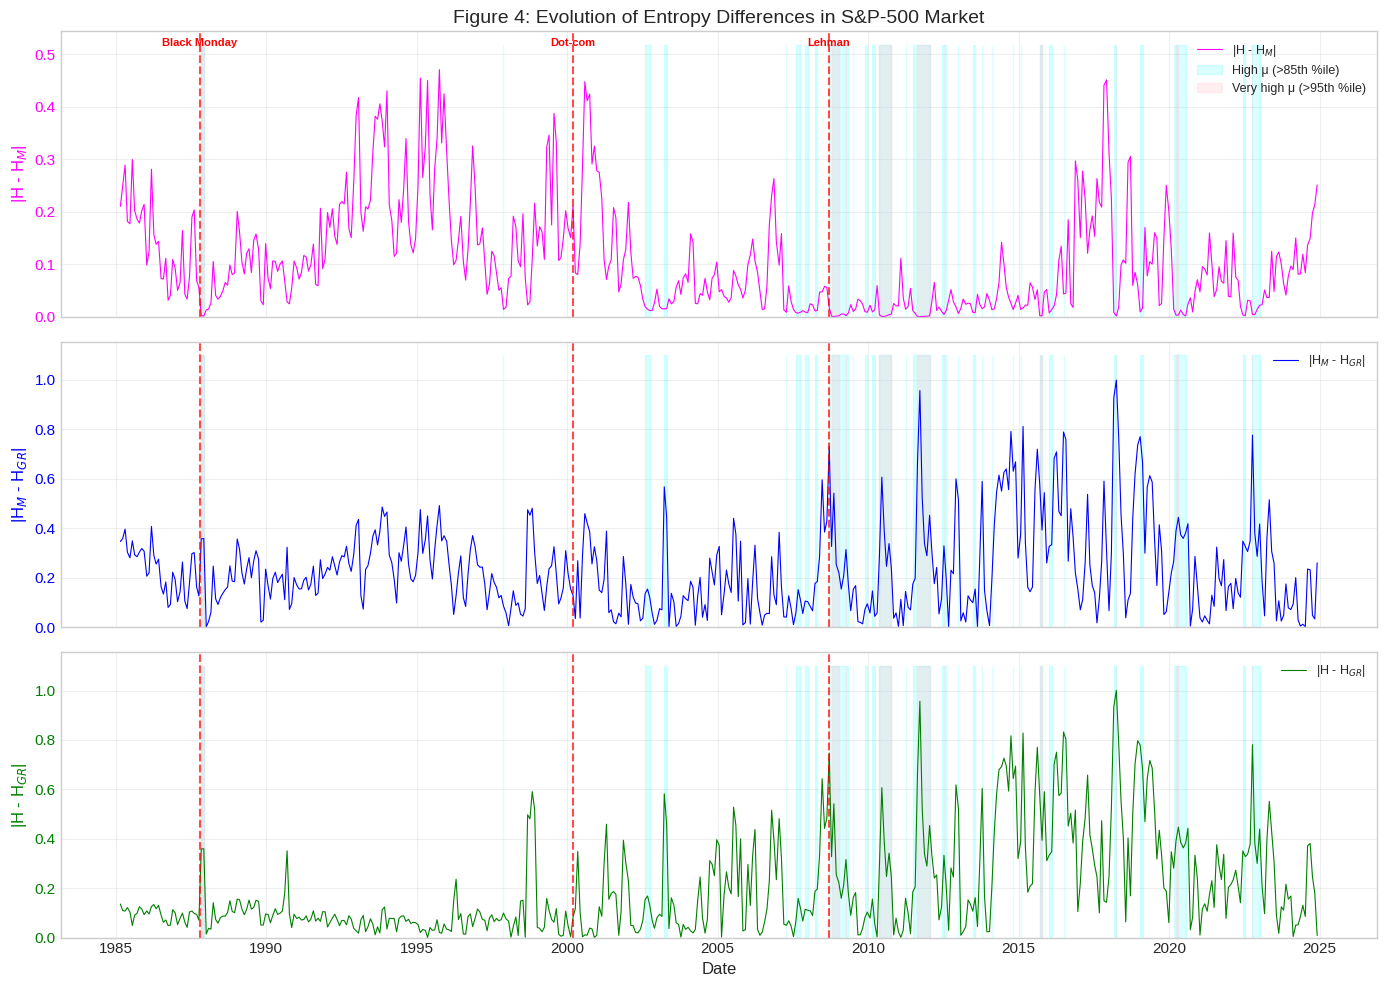

In [80]:
# =============================================================================
# FIGURE 4: TIME EVOLUTION OF ENTROPY DIFFERENCES (Paper's Figure 4)
# =============================================================================

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Define high correlation periods for colored bands
high_corr_threshold = results['mu'].quantile(0.85)
very_high_corr = results['mu'].quantile(0.95)

high_corr_mask = results['mu'] > high_corr_threshold
very_high_corr_mask = results['mu'] > very_high_corr

# Major crash dates for vertical lines
crash_dates = [
    ('1987-10-19', 'Black Monday'),
    ('2000-03-10', 'Dot-com'),
    ('2008-09-15', 'Lehman'),
]

# Panel 1: |H - H_M| (magenta in paper)
ax = axes[0]
ax.plot(results['date'], results['abs_H_minus_HM'], color='magenta', linewidth=0.8, label='|H - H$_M$|')
ax.fill_between(results['date'], 0, results['abs_H_minus_HM'].max() * 1.1,
                where=high_corr_mask, alpha=0.15, color='cyan', label='High μ (>85th %ile)')
ax.fill_between(results['date'], 0, results['abs_H_minus_HM'].max() * 1.1,
                where=very_high_corr_mask, alpha=0.25, color='pink', label='Very high μ (>95th %ile)')
ax.set_ylabel('|H - H$_M$|', fontsize=12, color='magenta')
ax.set_title('Figure 4: Evolution of Entropy Differences in S&P-500 Market', fontsize=14)
ax.set_ylim(bottom=0)
ax.tick_params(axis='y', labelcolor='magenta')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 2: |H_M - H_GR| (blue in paper)
ax = axes[1]
ax.plot(results['date'], results['HM_minus_HGR'].abs(), color='blue', linewidth=0.8, label='|H$_M$ - H$_{GR}$|')
ax.fill_between(results['date'], 0, results['HM_minus_HGR'].abs().max() * 1.1,
                where=high_corr_mask, alpha=0.15, color='cyan')
ax.fill_between(results['date'], 0, results['HM_minus_HGR'].abs().max() * 1.1,
                where=very_high_corr_mask, alpha=0.25, color='pink')
ax.set_ylabel('|H$_M$ - H$_{GR}$|', fontsize=12, color='blue')
ax.set_ylim(bottom=0)
ax.tick_params(axis='y', labelcolor='blue')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 3: |H - H_GR| (green in paper)
ax = axes[2]
ax.plot(results['date'], results['abs_H_minus_HGR'], color='green', linewidth=0.8, label='|H - H$_{GR}$|')
ax.fill_between(results['date'], 0, results['abs_H_minus_HGR'].max() * 1.1,
                where=high_corr_mask, alpha=0.15, color='cyan')
ax.fill_between(results['date'], 0, results['abs_H_minus_HGR'].abs().max() * 1.1,
                where=very_high_corr_mask, alpha=0.25, color='pink')
ax.set_ylabel('|H - H$_{GR}$|', fontsize=12, color='green')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylim(bottom=0)
ax.tick_params(axis='y', labelcolor='green')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# Add crash markers with labels
for ax_idx, ax in enumerate(axes):
    for cd, name in crash_dates:
        try:
            ax.axvline(pd.Timestamp(cd), color='red', linestyle='--', alpha=0.7, linewidth=1.5)
            # Add label only on top panel
            if ax_idx == 0:
                ax.annotate(name, xy=(pd.Timestamp(cd), ax.get_ylim()[1]*0.95), 
                           fontsize=8, ha='center', color='red', fontweight='bold')
        except:
            pass

plt.tight_layout()
plt.show()


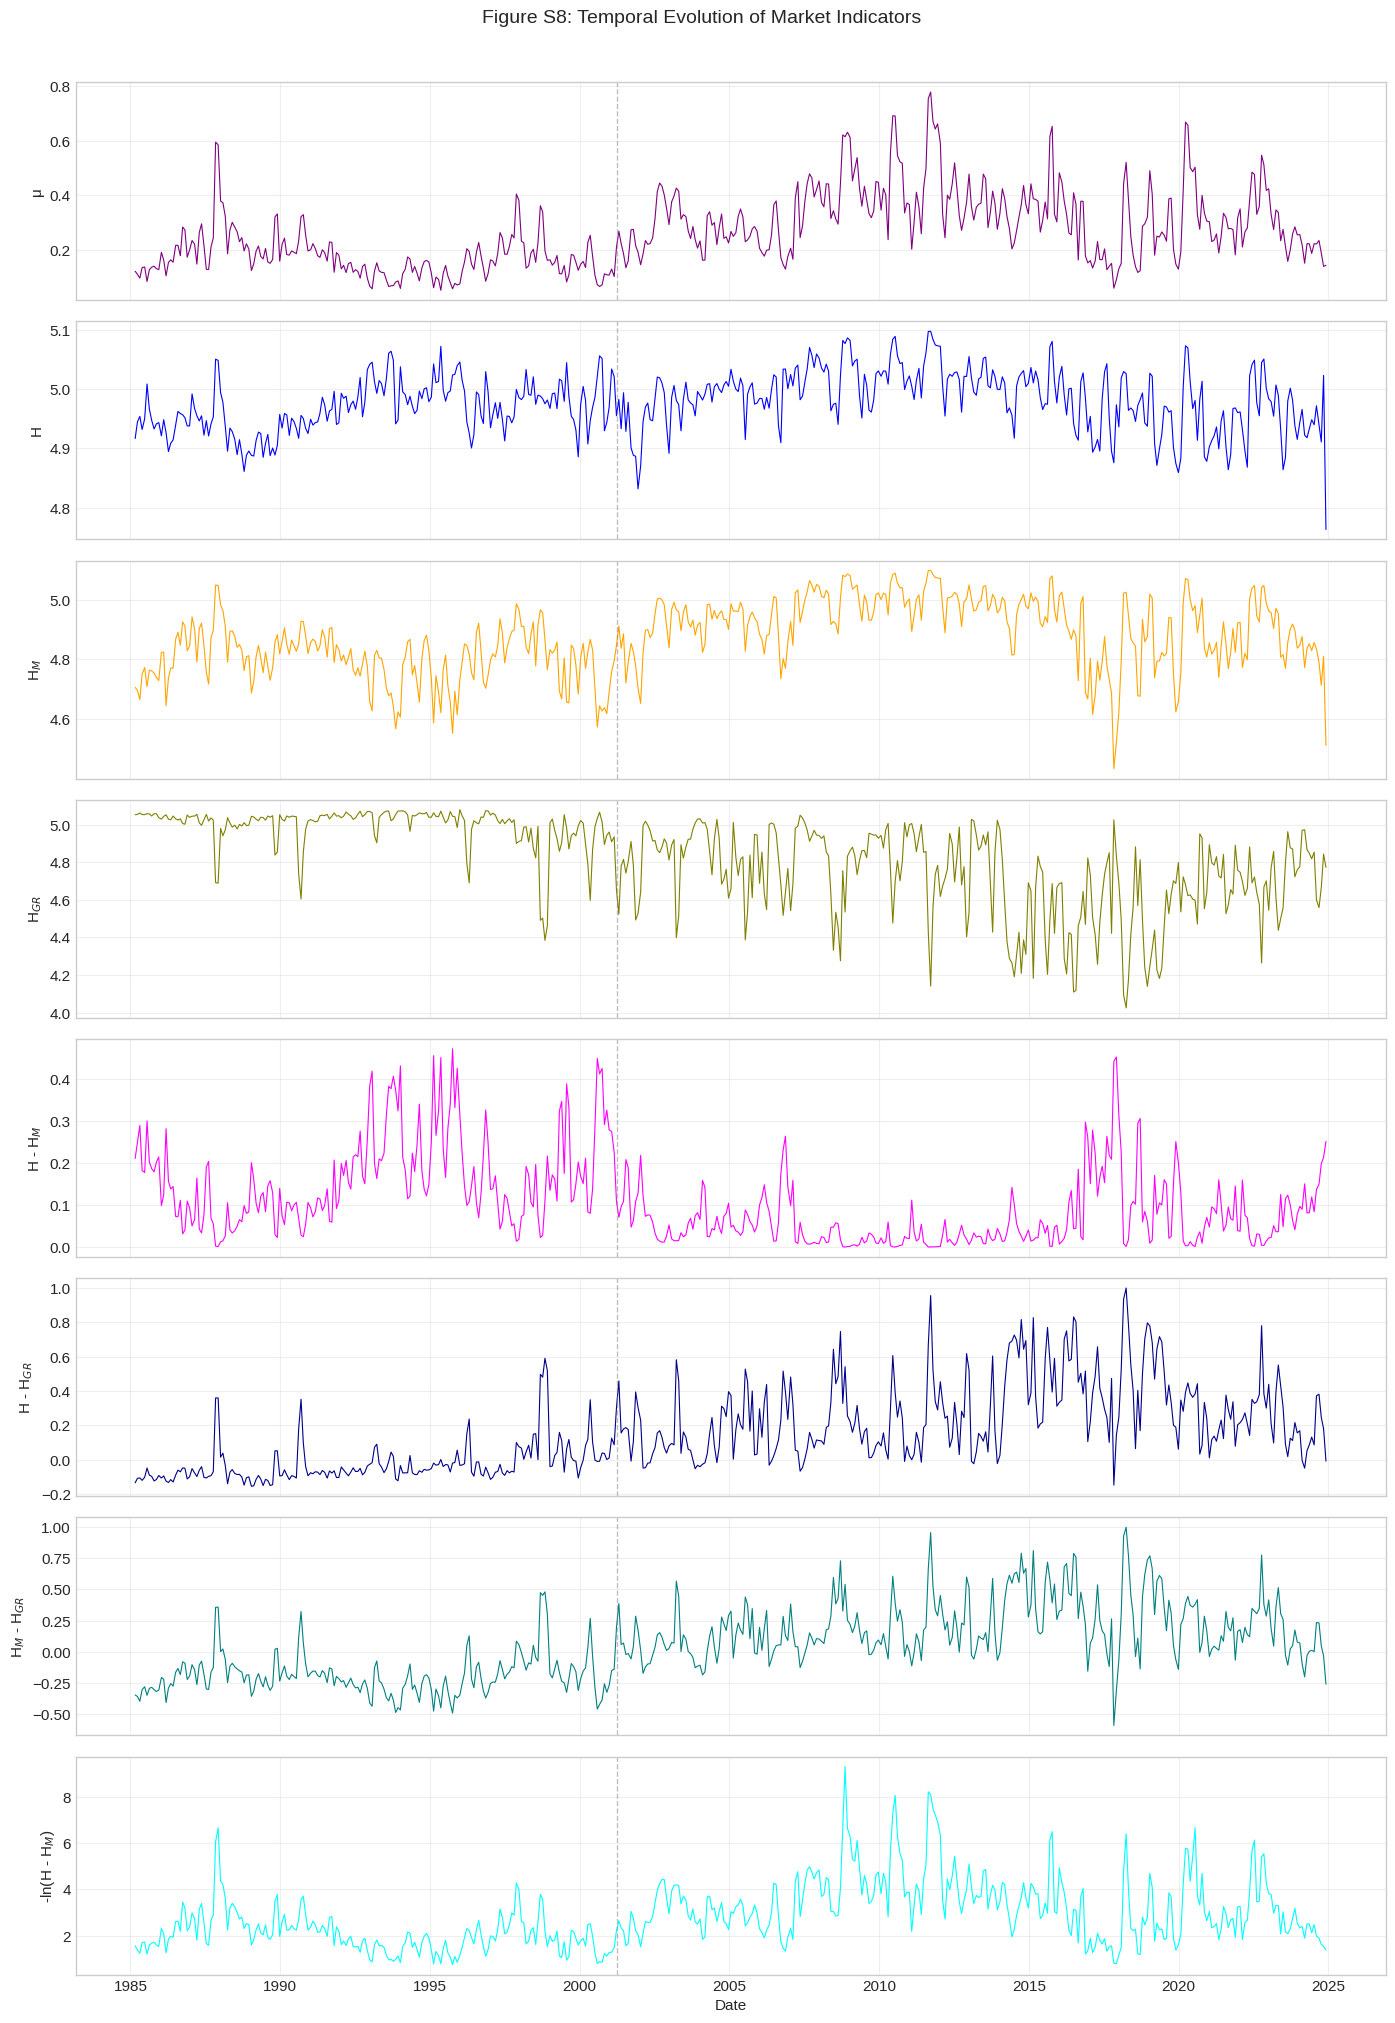

In [81]:
# =============================================================================
# FIGURE S8: FULL TEMPORAL EVOLUTION (8 PANELS)
# =============================================================================

fig, axes = plt.subplots(8, 1, figsize=(14, 20), sharex=True)

# Define variables and colors (matching paper's Figure S8)
plot_data = [
    ('mu', 'μ', 'purple'),
    ('H', 'H', 'blue'),
    ('H_M', 'H$_M$', 'orange'),
    ('H_GR', 'H$_{GR}$', 'olive'),
    ('H_minus_HM', 'H - H$_M$', 'magenta'),
    ('H_minus_HGR', 'H - H$_{GR}$', 'darkblue'),
    ('HM_minus_HGR', 'H$_M$ - H$_{GR}$', 'teal'),
]

# Plot first 7 variables
for ax, (col, label, color) in zip(axes[:7], plot_data):
    ax.plot(results['date'], results[col], color=color, linewidth=0.8)
    ax.set_ylabel(label, fontsize=11)
    ax.grid(True, alpha=0.3)

# Panel 8: -ln(H - H_M) - the fear gauge
ax = axes[7]
neg_ln_H = -np.log(results['H_minus_HM'].clip(lower=1e-10))
ax.plot(results['date'], neg_ln_H, color='cyan', linewidth=0.8)
ax.set_ylabel('-ln(H - H$_M$)', fontsize=11)
ax.set_xlabel('Date', fontsize=11)
ax.grid(True, alpha=0.3)

# Add regime change line (April 2001 mentioned in paper)
for ax in axes:
    ax.axvline(pd.Timestamp('2001-04-01'), color='gray', linestyle='--', alpha=0.5, linewidth=1)

plt.suptitle('Figure S8: Temporal Evolution of Market Indicators', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

Phase-based regime distribution:
phase_regime
Normal     359
Crash       61
Type-2      43
Anomaly     33
Type-1       6
Name: count, dtype: int64


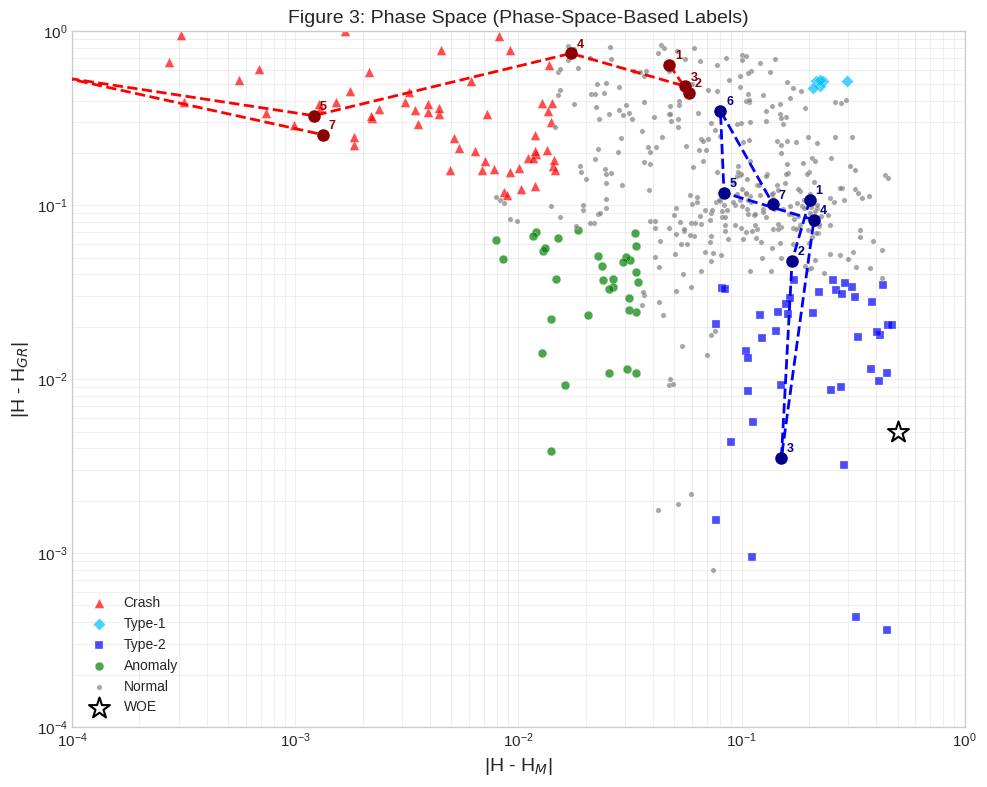

In [82]:
# =============================================================================
# FIGURE 3: PHASE SPACE (MATCHING PAPER EXACTLY)
# =============================================================================

fig, ax = plt.subplots(figsize=(10, 8))

# =============================================================================
# RE-LABEL REGIMES BASED ON PHASE SPACE POSITION (not calendar dates)
# =============================================================================

results_plot = results.copy()

# Define thresholds based on phase space position
H_HM_low = results_plot['abs_H_minus_HM'].quantile(0.15)    # Low |H-H_M| → Crash
H_HM_high = results_plot['abs_H_minus_HM'].quantile(0.85)   # High |H-H_M|
H_HGR_low = results_plot['abs_H_minus_HGR'].quantile(0.15)  # Low |H-H_GR| → Type-2
H_HGR_high = results_plot['abs_H_minus_HGR'].quantile(0.85) # High |H-H_GR|

# Assign regimes based on phase space position
results_plot['phase_regime'] = 'Normal'

# CRASH: Low |H-H_M|, High |H-H_GR| (top-left)
crash_mask = (results_plot['abs_H_minus_HM'] < H_HM_low) & \
             (results_plot['abs_H_minus_HGR'] > results_plot['abs_H_minus_HGR'].quantile(0.5))
results_plot.loc[crash_mask, 'phase_regime'] = 'Crash'

# TYPE-1: High |H-H_M|, High |H-H_GR| (top-right)
type1_mask = (results_plot['abs_H_minus_HM'] > H_HM_high) & \
             (results_plot['abs_H_minus_HGR'] > H_HGR_high)
results_plot.loc[type1_mask, 'phase_regime'] = 'Type-1'

# TYPE-2: High |H-H_M|, Low |H-H_GR| (bottom-right)
type2_mask = (results_plot['abs_H_minus_HM'] > results_plot['abs_H_minus_HM'].quantile(0.5)) & \
             (results_plot['abs_H_minus_HGR'] < H_HGR_low)
results_plot.loc[type2_mask, 'phase_regime'] = 'Type-2'

# ANOMALY: Low |H-H_M|, Low |H-H_GR| (bottom-left, near origin)
anomaly_mask = (results_plot['abs_H_minus_HM'] < results_plot['abs_H_minus_HM'].quantile(0.3)) & \
               (results_plot['abs_H_minus_HGR'] < results_plot['abs_H_minus_HGR'].quantile(0.3))
results_plot.loc[anomaly_mask, 'phase_regime'] = 'Anomaly'

print("Phase-based regime distribution:")
print(results_plot['phase_regime'].value_counts())

# =============================================================================
# PLOT WITH DIFFERENT MARKERS (matching paper)
# =============================================================================

# Marker styles matching paper
MARKERS = {
    'Crash': ('^', 'red', 50),        # Triangle
    'Type-1': ('D', 'deepskyblue', 40), # Diamond
    'Type-2': ('s', 'blue', 40),       # Square
    'Anomaly': ('o', 'green', 40),     # Circle
    'Normal': ('o', 'gray', 15),       # Small circle
}

for regime, (marker, color, size) in MARKERS.items():
    mask = results_plot['phase_regime'] == regime
    if mask.any():
        ax.scatter(results_plot.loc[mask, 'abs_H_minus_HM'] + 1e-6,
                  results_plot.loc[mask, 'abs_H_minus_HGR'] + 1e-6,
                  marker=marker, c=color, s=size, label=regime,
                  alpha=0.7, edgecolors='white', linewidth=0.3, zorder=2)

# WOE reference - BOTTOM-RIGHT (high |H-H_M|, low |H-H_GR|) 
# This is where random Wishart matrix would be
ax.scatter([0.5], [0.005], c='white', marker='*', s=250, 
           edgecolors='black', linewidth=1.5, label='WOE', zorder=5)

# =============================================================================
# TRANSITION SEQUENCES
# =============================================================================

def get_transition_sequence(results_df, event_date, n_before=3, n_after=3):
    results_df = results_df.reset_index(drop=True)
    date_diffs = (results_df['date'] - pd.Timestamp(event_date)).abs()
    center_idx = date_diffs.idxmin()
    start_idx = max(0, center_idx - n_before)
    end_idx = min(len(results_df) - 1, center_idx + n_after)
    return results_df.iloc[start_idx:end_idx + 1]

# Crash sequence (Lehman 2008) - RED dashed line
crash_seq = get_transition_sequence(results_plot, '2008-09-15', 3, 3)
if len(crash_seq) > 1:
    x = crash_seq['abs_H_minus_HM'].values + 1e-6
    y = crash_seq['abs_H_minus_HGR'].values + 1e-6
    ax.plot(x, y, 'r--', linewidth=2, zorder=4, marker='o', markersize=8,
            markerfacecolor='darkred', markeredgecolor='darkred')
    for i, (xi, yi) in enumerate(zip(x, y)):
        ax.annotate(str(i+1), (xi, yi), fontsize=9, fontweight='bold',
                   color='darkred', xytext=(4, 4), textcoords='offset points', zorder=6)

# Bubble sequence (Dot-com 2000) - BLUE dashed line
bubble_seq = get_transition_sequence(results_plot, '2000-03-10', 3, 3)
if len(bubble_seq) > 1:
    x = bubble_seq['abs_H_minus_HM'].values + 1e-6
    y = bubble_seq['abs_H_minus_HGR'].values + 1e-6
    ax.plot(x, y, 'b--', linewidth=2, zorder=4, marker='o', markersize=8,
            markerfacecolor='darkblue', markeredgecolor='darkblue')
    for i, (xi, yi) in enumerate(zip(x, y)):
        ax.annotate(str(i+1), (xi, yi), fontsize=9, fontweight='bold',
                   color='darkblue', xytext=(4, 4), textcoords='offset points', zorder=6)

# =============================================================================
# FORMATTING
# =============================================================================

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('|H - H$_M$|', fontsize=14)
ax.set_ylabel('|H - H$_{GR}$|', fontsize=14)
ax.set_title('Figure 3: Phase Space (Phase-Space-Based Labels)', fontsize=14)
ax.legend(loc='lower left', fontsize=10, framealpha=0.9)  # ← MOVED TO BOTTOM LEFT
ax.grid(True, alpha=0.3, which='both')
ax.set_xlim([1e-4, 1e0])
ax.set_ylim([1e-4, 1e0])

plt.tight_layout()
plt.show()

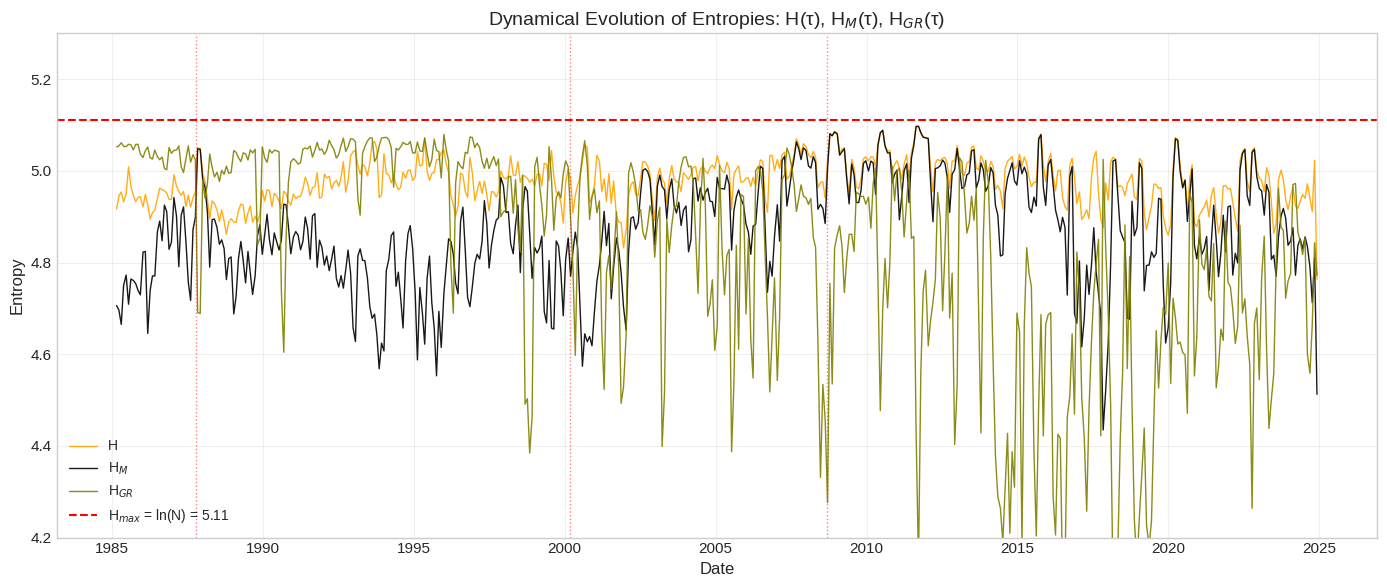

In [83]:
# =============================================================================
# FIGURE 2a: DYNAMICAL EVOLUTION OF ENTROPIES
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 6))

# Plot the three entropies
ax.plot(results['date'], results['H'], color='orange', linewidth=1, label='H', alpha=0.9)
ax.plot(results['date'], results['H_M'], color='black', linewidth=1, label='H$_M$', alpha=0.9)
ax.plot(results['date'], results['H_GR'], color='olive', linewidth=1, label='H$_{GR}$', alpha=0.9)

# Add H_max reference line
H_max = results['H_max'].iloc[0]
ax.axhline(y=H_max, color='red', linestyle='--', linewidth=1.5, label=f'H$_{{max}}$ = ln(N) = {H_max:.2f}')

# Add crash markers
crash_dates = [
    ('1987-10-19', 'Black Monday'),
    ('2000-03-10', 'Dot-com'),
    ('2008-09-15', 'Lehman'),
]
for date, name in crash_dates:
    try:
        ax.axvline(pd.Timestamp(date), color='red', linestyle=':', alpha=0.5, linewidth=1)
    except:
        pass

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Entropy', fontsize=12)
ax.set_title('Dynamical Evolution of Entropies: H(τ), H$_M$(τ), H$_{GR}$(τ)', fontsize=14)
ax.legend(loc='lower left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim([4.2, 5.3])

plt.tight_layout()
plt.show()

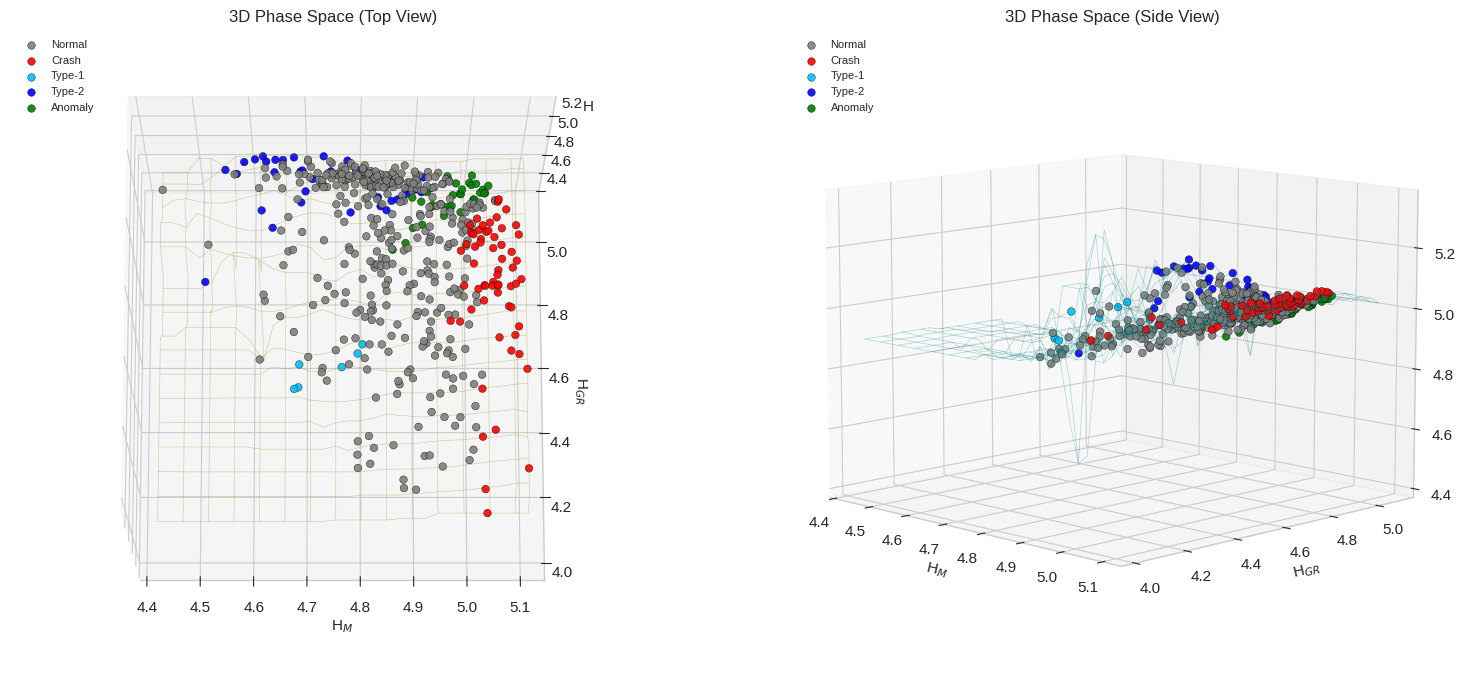

In [84]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

fig = plt.figure(figsize=(16, 7))

# Create grid and interpolate
H_M_data = results_plot['H_M'].values
H_GR_data = results_plot['H_GR'].values
H_data = results_plot['H'].values

H_M_range = np.linspace(H_M_data.min(), H_M_data.max(), 30)
H_GR_range = np.linspace(H_GR_data.min(), H_GR_data.max(), 30)
H_M_mesh, H_GR_mesh = np.meshgrid(H_M_range, H_GR_range)

H_surface = griddata((H_M_data, H_GR_data), H_data, 
                     (H_M_mesh, H_GR_mesh), method='cubic')
H_surface_nearest = griddata((H_M_data, H_GR_data), H_data, 
                             (H_M_mesh, H_GR_mesh), method='nearest')
H_surface = np.where(np.isnan(H_surface), H_surface_nearest, H_surface)

# =============================================================================
# TOP VIEW WITH WIREFRAME
# =============================================================================
ax1 = fig.add_subplot(121, projection='3d')

# Wireframe surface (like paper)
ax1.plot_wireframe(H_M_mesh, H_GR_mesh, H_surface, 
                   color='olive', alpha=0.3, linewidth=0.5, 
                   rstride=2, cstride=2)

for regime, color in COLORS_3D.items():
    mask = results_plot['phase_regime'] == regime
    if mask.any():
        ax1.scatter(results_plot.loc[mask, 'H_M'],
                   results_plot.loc[mask, 'H_GR'],
                   results_plot.loc[mask, 'H'],
                   c=color, s=30, alpha=0.9, label=regime,
                   edgecolors='k', linewidth=0.3, zorder=10)

ax1.set_xlabel('H$_M$', fontsize=11)
ax1.set_ylabel('H$_{GR}$', fontsize=11)
ax1.set_zlabel('H', fontsize=11)
ax1.set_title('3D Phase Space (Top View)', fontsize=12)
ax1.view_init(elev=75, azim=-90)
ax1.legend(loc='upper left', fontsize=8)

# =============================================================================
# SIDE VIEW WITH WIREFRAME
# =============================================================================
ax2 = fig.add_subplot(122, projection='3d')

ax2.plot_wireframe(H_M_mesh, H_GR_mesh, H_surface, 
                   color='teal', alpha=0.3, linewidth=0.5,
                   rstride=2, cstride=2)

for regime, color in COLORS_3D.items():
    mask = results_plot['phase_regime'] == regime
    if mask.any():
        ax2.scatter(results_plot.loc[mask, 'H_M'],
                   results_plot.loc[mask, 'H_GR'],
                   results_plot.loc[mask, 'H'],
                   c=color, s=30, alpha=0.9, label=regime,
                   edgecolors='k', linewidth=0.3, zorder=10)

ax2.set_xlabel('H$_M$', fontsize=11)
ax2.set_ylabel('H$_{GR}$', fontsize=11)
ax2.set_zlabel('H', fontsize=11)
ax2.set_title('3D Phase Space (Side View)', fontsize=12)
ax2.view_init(elev=15, azim=-50)
ax2.legend(loc='upper left', fontsize=8)
# ax1.view_init(elev=90, azim=-90)
ax2.view_init(elev=10, azim=-45)

plt.tight_layout()
plt.show()

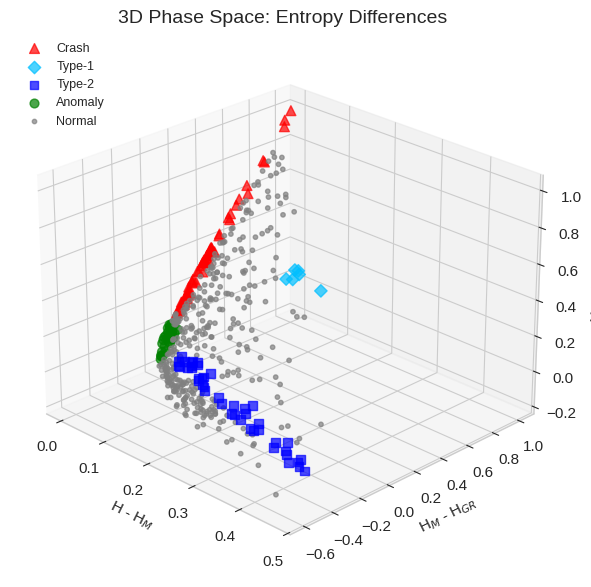

In [86]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Use phase-space regimes
results_plot = results.copy()

H_HM_low = results_plot['abs_H_minus_HM'].quantile(0.15)
H_HM_high = results_plot['abs_H_minus_HM'].quantile(0.85)
H_HGR_low = results_plot['abs_H_minus_HGR'].quantile(0.15)
H_HGR_high = results_plot['abs_H_minus_HGR'].quantile(0.85)

results_plot['phase_regime'] = 'Normal'
crash_mask = (results_plot['abs_H_minus_HM'] < H_HM_low) & \
             (results_plot['abs_H_minus_HGR'] > results_plot['abs_H_minus_HGR'].quantile(0.5))
results_plot.loc[crash_mask, 'phase_regime'] = 'Crash'
type1_mask = (results_plot['abs_H_minus_HM'] > H_HM_high) & \
             (results_plot['abs_H_minus_HGR'] > H_HGR_high)
results_plot.loc[type1_mask, 'phase_regime'] = 'Type-1'
type2_mask = (results_plot['abs_H_minus_HM'] > results_plot['abs_H_minus_HM'].quantile(0.5)) & \
             (results_plot['abs_H_minus_HGR'] < H_HGR_low)
results_plot.loc[type2_mask, 'phase_regime'] = 'Type-2'
anomaly_mask = (results_plot['abs_H_minus_HM'] < results_plot['abs_H_minus_HM'].quantile(0.3)) & \
               (results_plot['abs_H_minus_HGR'] < results_plot['abs_H_minus_HGR'].quantile(0.3))
results_plot.loc[anomaly_mask, 'phase_regime'] = 'Anomaly'

# Markers and colors
MARKERS_3D = {
    'Crash': ('^', 'red', 50),
    'Type-1': ('D', 'deepskyblue', 40),
    'Type-2': ('s', 'blue', 40),
    'Anomaly': ('o', 'green', 40),
    'Normal': ('o', 'gray', 10),
}

for regime, (marker, color, size) in MARKERS_3D.items():
    mask = results_plot['phase_regime'] == regime
    if mask.any():
        ax.scatter(results_plot.loc[mask, 'H_minus_HM'],
                  results_plot.loc[mask, 'HM_minus_HGR'],
                  results_plot.loc[mask, 'H_minus_HGR'],
                  marker=marker, c=color, s=size, alpha=0.7, label=regime)

ax.set_xlabel('H - H$_M$', fontsize=11)
ax.set_ylabel('H$_M$ - H$_{GR}$', fontsize=11)
ax.set_zlabel('H - H$_{GR}$', fontsize=11)
ax.set_title('3D Phase Space: Entropy Differences', fontsize=14)
ax.legend(loc='upper left', fontsize=9)
ax.view_init(elev=25, azim=-45)

plt.tight_layout()
plt.show()

---
## Step 7: Summary Statistics and Validation

In [87]:
# Summary statistics by regime
print("="*70)
print("SUMMARY STATISTICS BY REGIME")
print("="*70)

for regime in ['normal', 'crash', 'bubble', 'type-1']:
    subset = results[results['regime'] == regime]
    if len(subset) > 0:
        print(f"\n{regime.upper()} (n={len(subset)}):")
        print(f"  H:          mean={subset['H'].mean():.4f}, std={subset['H'].std():.4f}")
        print(f"  H_M:        mean={subset['H_M'].mean():.4f}, std={subset['H_M'].std():.4f}")
        print(f"  H_GR:       mean={subset['H_GR'].mean():.4f}, std={subset['H_GR'].std():.4f}")
        print(f"  |H - H_M|:  mean={subset['abs_H_minus_HM'].mean():.4f}")
        print(f"  |H - H_GR|: mean={subset['abs_H_minus_HGR'].mean():.4f}")
        print(f"  μ (corr):   mean={subset['mu'].mean():.4f}, std={subset['mu'].std():.4f}")

SUMMARY STATISTICS BY REGIME

NORMAL (n=417):
  H:          mean=4.9774, std=0.0502
  H_M:        mean=4.8685, std=0.1217
  H_GR:       mean=4.8254, std=0.2456
  |H - H_M|:  mean=0.1089
  |H - H_GR|: mean=0.2059
  μ (corr):   mean=0.2642, std=0.1365

CRASH (n=24):
  H:          mean=4.9798, std=0.0609
  H_M:        mean=4.9248, std=0.1014
  H_GR:       mean=4.8233, std=0.2210
  |H - H_M|:  mean=0.0550
  |H - H_GR|: mean=0.2236
  μ (corr):   mean=0.3450, std=0.1768

BUBBLE (n=60):
  H:          mean=4.9791, std=0.0457
  H_M:        mean=4.8720, std=0.0984
  H_GR:       mean=4.8310, std=0.1704
  |H - H_M|:  mean=0.1072
  |H - H_GR|: mean=0.1642
  μ (corr):   mean=0.2396, std=0.0900

TYPE-1 (n=1):
  H:          mean=4.9856, std=nan
  H_M:        mean=4.6886, std=nan
  H_GR:       mean=4.4693, std=nan
  |H - H_M|:  mean=0.2969
  |H - H_GR|: mean=0.5163
  μ (corr):   mean=0.1790, std=nan


In [88]:
# Validate against paper's key findings
print("="*70)
print("VALIDATION AGAINST PAPER'S FINDINGS")
print("="*70)

print("\n1. During CRASHES:")
print("   Paper says: H ≈ H_M (so |H - H_M| → 0)")
crash_data = results[results['regime'] == 'crash']
if len(crash_data) > 0:
    print(f"   Our result: |H - H_M| = {crash_data['abs_H_minus_HM'].mean():.4f}")

print("\n2. Maximum entropy should approach ln(N):")
print(f"   H_max = ln({N_STOCKS}) = {np.log(N_STOCKS):.4f}")
print(f"   Max H observed: {results['H'].max():.4f}")

print("\n3. Scaling relation (H - H_M) ~ exp(-β*μ):")
print("   Paper finds: α ≈ 0.85, β ≈ 10.22")
print("   (Check the fit in the scaling plot above)")

print("\n4. Correlation during crashes vs normal:")
normal_mu = results[results['regime'] == 'normal']['mu'].mean()
if len(crash_data) > 0:
    crash_mu = crash_data['mu'].mean()
    print(f"   Normal: μ = {normal_mu:.4f}")
    print(f"   Crash:  μ = {crash_mu:.4f}")
    print(f"   (Crashes should have higher correlation)")

VALIDATION AGAINST PAPER'S FINDINGS

1. During CRASHES:
   Paper says: H ≈ H_M (so |H - H_M| → 0)
   Our result: |H - H_M| = 0.0550

2. Maximum entropy should approach ln(N):
   H_max = ln(166) = 5.1120
   Max H observed: 5.0974

3. Scaling relation (H - H_M) ~ exp(-β*μ):
   Paper finds: α ≈ 0.85, β ≈ 10.22
   (Check the fit in the scaling plot above)

4. Correlation during crashes vs normal:
   Normal: μ = 0.2642
   Crash:  μ = 0.3450
   (Crashes should have higher correlation)
